# FER2013

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Libraries

In [ ]:
import os
import torch
import random
import cv2

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from tqdm.notebook import tqdm

#Para procesamiento de video
from moviepy.editor import *

# Para manejar imágenes
from PIL import Image, ImageDraw

Running on device: cpu


## Paths

In [ ]:
DATASETS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/"
FER2013_PATH = "FER2013/fer2013/fer2013.csv"

## Functions

In [ ]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def plot_figure(img):
  plt.figure(figsize=[2,2])
  plt.imshow(img, cmap='gray')

## Dataset

In [ ]:
df = pd.read_csv(DATASETS_PATH + FER2013_PATH)

In [ ]:
df.sample(5)

,emotion,pixels,Usage
4215,3,145 144 147 126 54 29 29 26 22 30 48 76 94 108...,Training
12317,3,21 25 22 20 30 33 34 30 49 52 12 11 16 21 24 2...,Training
32477,6,171 167 165 171 174 178 167 168 164 150 106 11...,PrivateTest
32963,5,109 81 34 20 18 10 5 9 13 13 14 15 15 15 17 17...,PrivateTest
10478,3,244 244 243 247 236 197 214 212 183 186 193 20...,Training


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


### Usage

In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Emotion

In [ ]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
expressions = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

In [ ]:
df['expression_name'] = df['emotion']
df['expression_name'] = df['expression_name'].replace(expressions)
df['expression_name'].value_counts()

happy       8989
neutral     6198
sad         6077
fear        5121
angry       4953
surprise    4002
disgust      547
Name: expression_name, dtype: int64

In [ ]:
df.head()

,emotion,pixels,Usage,expression_name
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


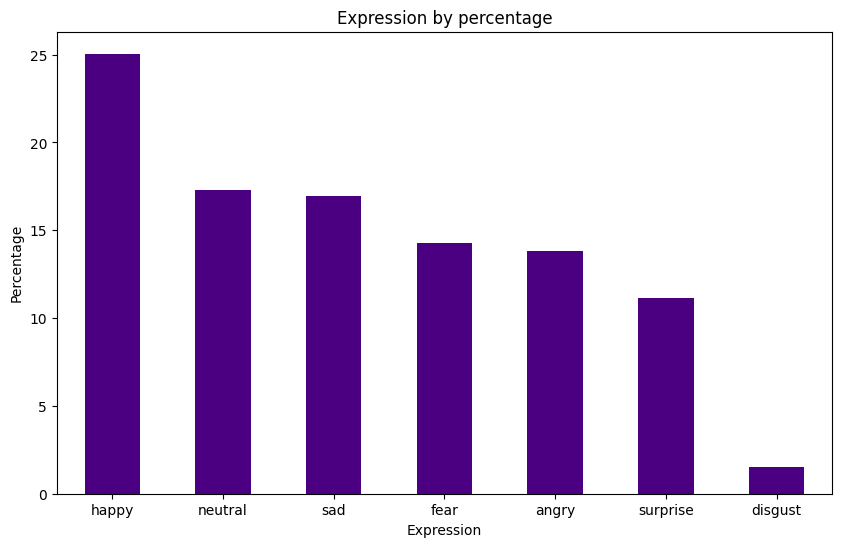

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

df['expression_name'].value_counts(normalize=True).map(lambda x: x * 100).\
    plot(kind='bar', ax=ax, title='Expression by percentage', color='indigo',
         xlabel='Expression', ylabel='Percentage', rot=0)

plt.show()

### Pixels

In [ ]:
image_array, image_label = prepare_data(df)

In [ ]:
image_array

array([[[ 70.,  80.,  82., ...,  52.,  43.,  41.],
        [ 65.,  61.,  58., ...,  56.,  52.,  44.],
        [ 50.,  43.,  54., ...,  49.,  56.,  47.],
        ...,
        [ 91.,  65.,  42., ...,  72.,  56.,  43.],
        [ 77.,  82.,  79., ..., 105.,  70.,  46.],
        [ 77.,  72.,  84., ..., 106., 109.,  82.]],

       [[151., 150., 147., ..., 129., 140., 120.],
        [151., 149., 149., ..., 122., 141., 137.],
        [151., 151., 156., ..., 109., 123., 146.],
        ...,
        [188., 188., 121., ..., 185., 185., 186.],
        [188., 187., 196., ..., 186., 182., 187.],
        [186., 184., 185., ..., 193., 183., 184.]],

       [[231., 212., 156., ...,  44.,  27.,  16.],
        [229., 175., 148., ...,  27.,  35.,  27.],
        [214., 156., 157., ...,  28.,  22.,  28.],
        ...,
        [241., 245., 250., ...,  57., 101., 146.],
        [246., 250., 252., ...,  78., 105., 162.],
        [250., 251., 250., ...,  88., 110., 152.]],

       ...,

       [[ 17.,  17.,  16

In [ ]:
image_label

array([0, 0, 2, ..., 0, 3, 2])

In [ ]:
images = image_array.reshape((image_array.shape[0], 48, 48, 1))

In [ ]:
images

array([[[[ 70.],
         [ 80.],
         [ 82.],
         ...,
         [ 52.],
         [ 43.],
         [ 41.]],

        [[ 65.],
         [ 61.],
         [ 58.],
         ...,
         [ 56.],
         [ 52.],
         [ 44.]],

        [[ 50.],
         [ 43.],
         [ 54.],
         ...,
         [ 49.],
         [ 56.],
         [ 47.]],

        ...,

        [[ 91.],
         [ 65.],
         [ 42.],
         ...,
         [ 72.],
         [ 56.],
         [ 43.]],

        [[ 77.],
         [ 82.],
         [ 79.],
         ...,
         [105.],
         [ 70.],
         [ 46.]],

        [[ 77.],
         [ 72.],
         [ 84.],
         ...,
         [106.],
         [109.],
         [ 82.]]],


       [[[151.],
         [150.],
         [147.],
         ...,
         [129.],
         [140.],
         [120.]],

        [[151.],
         [149.],
         [149.],
         ...,
         [122.],
         [141.],
         [137.]],

        [[151.],
         [151.],
      

#### Grafiquemos ejemplos de cada emoción

In [ ]:
idx_angry = df[df['expression_name']=='angry'].index[0]
idx_disgust = df[df['expression_name']=='disgust'].index[0]
idx_fear = df[df['expression_name']=='fear'].index[0]
idx_happy = df[df['expression_name']=='happy'].index[0]
idx_sad = df[df['expression_name']=='sad'].index[0]
idx_surprise = df[df['expression_name']=='surprise'].index[0]
idx_neutral = df[df['expression_name']=='neutral'].index[0]

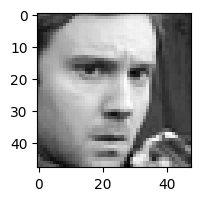

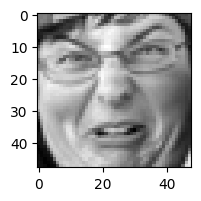

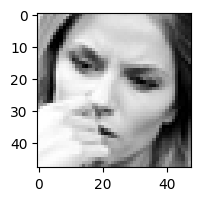

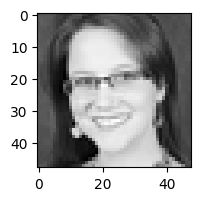

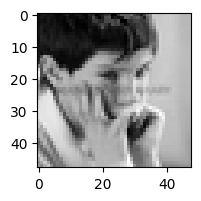

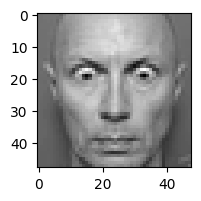

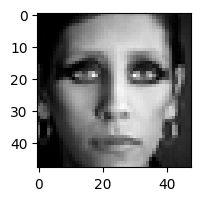

In [ ]:
plot_figure(images[idx_angry][:,:,0])
plot_figure(images[idx_disgust][:,:,0])
plot_figure(images[idx_fear][:,:,0])
plot_figure(images[idx_happy][:,:,0])
plot_figure(images[idx_sad][:,:,0])
plot_figure(images[idx_surprise][:,:,0])
plot_figure(images[idx_neutral][:,:,0])